In [1]:


import yaml, torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

from sklearn.manifold import TSNE

from tqdm import tqdm

from types import SimpleNamespace
import os, sys


In [2]:

project_dir = './msn'

if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
os.chdir(project_dir)


In [3]:
config_path = os.path.join( 'output','proto50_embed128' ,'config.yaml')

with open(config_path, 'r') as f:
        config_dict = yaml.safe_load(f)
        config = SimpleNamespace(**config_dict)

In [4]:
config

namespace(alpha_ema=0.996,
          attn_drop_rate=0.0,
          batch_size=64,
          data_root='./../../hyspecnet11k-PCA/',
          depth=9,
          drop_path_rate=0.0,
          drop_rate=0.0,
          embed_dim=128,
          epoch_stop_prototype=10,
          final_lr=1e-07,
          final_weight_decay=0.05,
          focal_crop_scale=[0.3, 0.5],
          focal_size=[64, 64, 32],
          focal_views=5,
          in_chans=1,
          lambda_reg=0.1,
          learning_rate=0.005,
          mask_ratio=0.5,
          mlp_ratio=4.0,
          num_epochs=20,
          num_heads=8,
          num_prototipos=50,
          num_workers=8,
          output_dir='./output/proto50_embed128',
          patch_size=[16, 16, 4],
          pin_memory=True,
          project_name='hsi-msn',
          rand_crop_scale=[0.8, 1.0],
          rand_size=[128, 128, 32],
          rand_views=2,
          resume_from=None,
          save_freq_epochs=50,
          spectral_jitter_strength=0.1,
 

## Load dataset

In [5]:
from src.dataset import init_data
from torch.utils.data import DataLoader

dataset = init_data(config_dict)


0it [00:00, ?it/s]

(64, 1, 32, 128, 128)


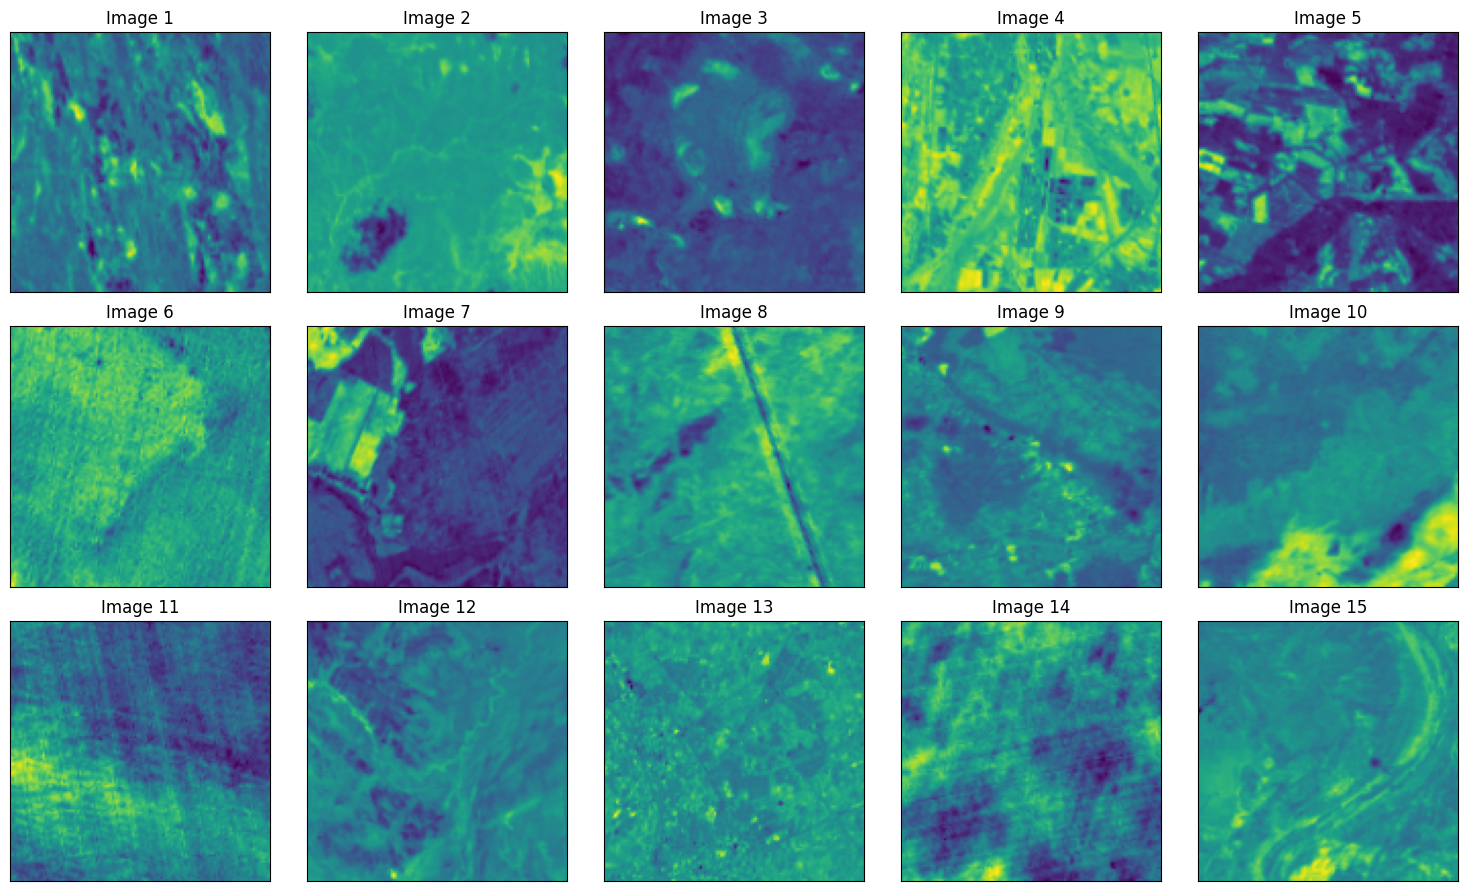

0it [00:04, ?it/s]


In [6]:
# the dataloader returns prisma_data, sentinel_data, airborne_data, 0

# plot 15 images from  airborne data  5x3 grid

#  withe theme

plt.style.use('default')


BAND_NUMBER = 2

for i, views in tqdm(enumerate(dataset)):
    views = [v for v in views]

     # shape [32, 1, 430, 20, 20] view[0] plot
     # view[0] to numpy

    view = views[0].detach().cpu().numpy()

    #plot
    print(view.shape)

    fig, axs = plt.subplots(3, 5, figsize=(15, 9))
    axs = axs.flatten()
    for j in range(15):
        axs[j].imshow(view[j,0, BAND_NUMBER, :, :])
        axs[j].set_title(f'Image {j+1}')
        axs[j].set_xticks([])
        axs[j].set_yticks([])
    plt.tight_layout()
    plt.show()

    break

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#device = "cpu"
from src.hsi_msn import MSNModel

model = MSNModel(config).to(device)


checkpoint_path = f"{config.output_dir}/min_loss_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])



<All keys matched successfully>

In [8]:
checkpoint["epoch"]

9

In [9]:
prot = model.prototypes
prot = prot.to(device)
prot = torch.nn.functional.normalize(prot, dim = 0 )
prot.shape

torch.Size([50, 128])

In [10]:
model.eval()

E = torch.empty(0, config.embed_dim).to(device)
F = torch.empty(0, prot.shape[0]).to(device)


count = 0

with torch.no_grad():

    # 10% dos dados
    for i , views in tqdm(enumerate(dataset)):
        count += 1

         # shape [32, 1, 430, 20, 20] view[0] plot
         # view[0] to numpy

        views = views[0].to(device)
        z_views = model.target_encoder(views)

        z_views = torch.nn.functional.normalize(z_views, dim=1)

        E = torch.cat((E, z_views), 0)

        F = torch.cat((F, z_views @ prot.T), 0)

        # if count == 20:
        #     break


0it [00:00, ?it/s]

180it [00:32,  5.46it/s]


In [11]:
# Concatenate prototypes and latent points
data = torch.cat((E.cpu(), prot.cpu()), dim=0).detach().numpy()

# Apply TSNE
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(data)

# Separate the results for prototypes and latent points
tsne_E = tsne_results[:E.shape[0]]
tsne_prot = tsne_results[E.shape[0]:]


In [12]:
import torch
import umap
# You may need to install the umap-learn package:
# pip install umap-learn

# Concatenate prototypes and latent points
data = torch.cat((E.cpu(), prot.cpu()), dim=0).detach().numpy()

# Apply UMAP
reducer = umap.UMAP(n_components=2)
umap_results = reducer.fit_transform(data)

# Separate the results for prototypes and latent points
umap_E = umap_results[:E.shape[0]]
umap_prot = umap_results[E.shape[0]:]

/home/emap/.pyenv/versions/hsi-msn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/emap/.pyenv/versions/hsi-msn/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [13]:
# value count clsuter labels

cluster_labels = torch.argmax(F, dim=1).cpu().numpy()     
cluster_labels = pd.Series(cluster_labels)
cluster_counts = cluster_labels.value_counts().sort_index()
print(cluster_counts) 

0     151
2     553
4     358
5     307
6       3
8     179
9      25
10     12
13    538
15    190
17    617
18    521
19    831
20    198
21    336
22     36
23    114
24    491
25    640
26    149
27     16
28    319
30    642
31    406
32    722
33    158
34    322
35    757
36     24
39    433
42    501
43    331
46    129
48    474
Name: count, dtype: int64


In [14]:
# read train_gt.csv

train_gt_path = os.path.join( './../train_files_with_gt.csv')
train_gt = pd.read_csv(train_gt_path)


train_gt = train_gt[0:len(E)]

In [15]:
len(train_gt), len(E)

(11483, 11483)

In [16]:
train_gt

,file,base_name,sample_index,P,K,Mg,pH
0,./../hyperview1/pca/train/00000_patch000.npy,0,0,45.1,188.0,179.0,7.2
1,./../hyperview1/pca/train/00001_patch000.npy,1,1,44.8,205.0,188.0,7.0
2,./../hyperview1/pca/train/00002_patch000.npy,2,2,44.4,207.0,145.0,6.8
3,./../hyperview1/pca/train/00003_patch000.npy,3,3,46.5,204.0,143.0,6.8
4,./../hyperview1/pca/train/00004_patch000.npy,4,4,52.0,212.0,167.0,6.7
...,...,...,...,...,...,...,...
11478,./../hyperview1/pca/train/01117_patch053.npy,1117,1117,68.3,280.0,156.0,6.8
11479,./../hyperview1/pca/train/01117_patch054.npy,1117,1117,68.3,280.0,156.0,6.8
11480,./../hyperview1/pca/train/01117_patch055.npy,1117,1117,68.3,280.0,156.0,6.8
11481,./../hyperview1/pca/train/01117_patch056.npy,1117,1117,68.3,280.0,156.0,6.8


In [17]:
# add patch column to train_gt 
# example of file name ./../hyperview1/pca/train/00000_patch000.npy 
# get number between patch and .npy

train_gt['patch'] = train_gt['file'].apply(lambda x: int(x.split('_patch')[1].split('.npy')[0]))

In [18]:
patch_index_0 = train_gt[train_gt['patch'] == 0].index

In [19]:
E_patch_0 = E[patch_index_0]
train_gt_patch_0 = train_gt.iloc[patch_index_0]

In [20]:
umap_patch_0 = umap_E[patch_index_0]

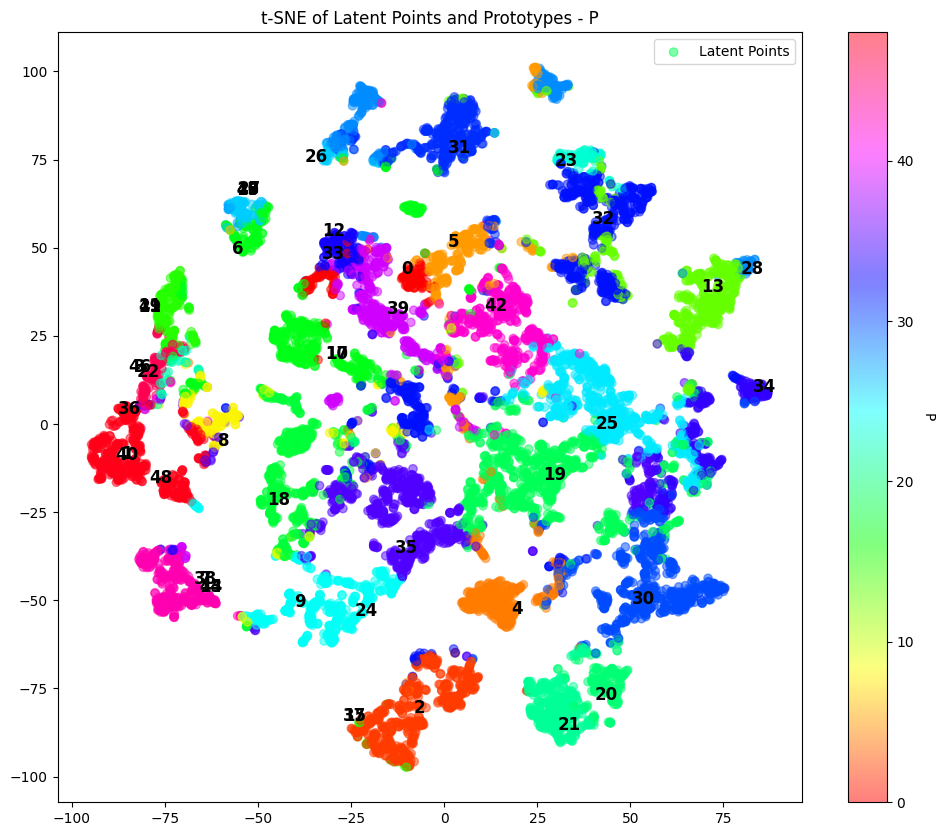

In [21]:

elemento = 'P'


# # Plotar os resultados do t-SNE
#cluster_labels = train_gt[elemento]
plt.figure(figsize=(12, 10))

# quero um cmap pra classes 
# Use 'c' para o mapeamento de cores e guarde o objeto do scatter plot
scatter = plt.scatter(tsne_E[:, 0], tsne_E[:, 1], c=cluster_labels, cmap='hsv', label='Latent Points', alpha=0.5)

# # # Adiciona a barra de cores and title
cbar = plt.colorbar(scatter)
cbar.set_label(elemento, rotation=270, labelpad=15) # Adiciona um rótulo à barra de cores



# Adiciona os protótipos ao gráfico
for i, (x, y) in enumerate(tsne_prot):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center', weight='bold')

plt.legend()
plt.title("t-SNE of Latent Points and Prototypes - {elemento}".format(elemento=elemento))

# title colorbar label
cbar.set_label(elemento, rotation=270, labelpad=15)

# Salva a figura em um arquivo
plt.savefig('tsne_plot.png')


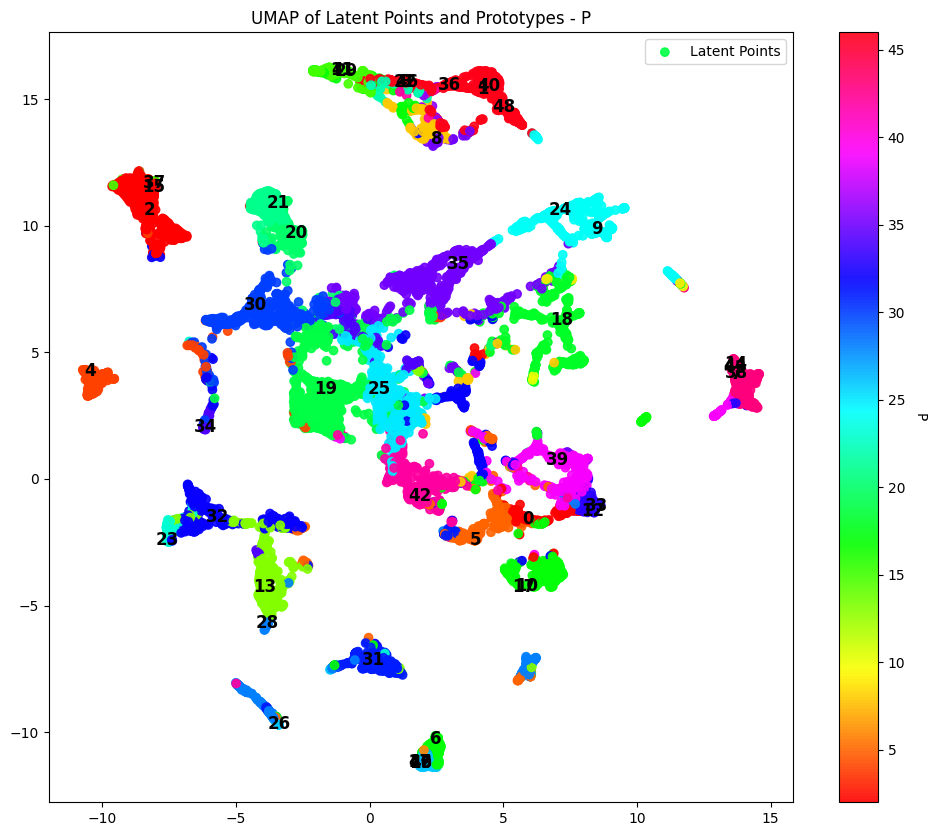

In [22]:

elemento = 'P'


# # Plotar os resultados do t-SNE
#cluster_labels = train_gt_patch_0[elemento]

# clip cluster labels percentile
lower_bound = np.percentile(cluster_labels, 5)
upper_bound = np.percentile(cluster_labels, 95)
cluster_labels = np.clip(cluster_labels, lower_bound, upper_bound)

plt.figure(figsize=(12, 10))

# quero um cmap pra classes 
# Use 'c' para o mapeamento de cores e guarde o objeto do scatter plot
scatter = plt.scatter(umap_E[:, 0], umap_E[:, 1], c=cluster_labels, cmap='hsv', label='Latent Points', alpha=0.9)

# # # Adiciona a barra de cores and title
cbar = plt.colorbar(scatter)
cbar.set_label(elemento, rotation=270, labelpad=15) # Adiciona um rótulo à barra de cores



# Adiciona os protótipos ao gráfico
for i, (x, y) in enumerate(umap_prot):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center', weight='bold')

plt.legend()
plt.title("UMAP of Latent Points and Prototypes - {elemento}".format(elemento=elemento))

# title colorbar label
cbar.set_label(elemento, rotation=270, labelpad=15)

# Salva a figura em um arquivo
plt.savefig('umap_plot.png')


In [23]:
# create a random forest to predict the train_gt[elemento] using the latent space E as input


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



X = E.cpu().numpy()
y = train_gt['K'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
print(f'R2 Score: {r2:.4f}')


KeyboardInterrupt: 

In [ ]:
# R2 score
from sklearn.metrics import r2_score
r2 = r2_score(y_test.numpy(), y_pred.numpy())
print(f'R2 Score: {r2:.4f}')

R2 Score: 0.1917
